In [1]:
import sys
import importlib
import numpy as np

sys.path.append("..")

from scripts.load_results import load_results

from strategic_ttc.verifiers.boxed_number import parse_pred_from_explanation
from strategic_ttc.verifiers.gpqa import parse_pred_from_explanation_gpqa


import strategic_ttc.core.accuracy_analysis_f as aa
import strategic_ttc.core.game_dynamics_f as gm
import scripts.utils as ut

/NL/strategic-compute/work/svenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
importlib.reload(aa)
importlib.reload(gm)
importlib.reload(ut)

<module 'scripts.utils' from '/NL/strategic-compute/work/strategic-ttc/notebooks/../scripts/utils.py'>

# Load results

In [3]:
BENCHMARK = "GSM8K"

In [4]:
results = load_results(f"../final_runs/{BENCHMARK}")

if BENCHMARK in {"GSM8K", "AIME"}:
    pred_fn = parse_pred_from_explanation
else:
    pred_fn = parse_pred_from_explanation_gpqa

model_color = ut.assign_colors(results.keys())
reasoning_models, unreasoning_models = ut.categorize_models(results.keys())

# Accuracy analysis

## Non-reasoning models

In [5]:
unreasoning_models_data = aa.unreasoning_models_data(
    unreasoning_models, results, pred_fn
)
models_data_llama, models_data_qwen = ut.categorize_families(unreasoning_models_data)

Processing Llama-3-8B...
Processing Llama-3.1-8B...
Processing Llama-3.2-1B...
Processing Llama-3.2-3B...
Processing Qwen2-0.5B...
Processing Qwen2-1.5B...
Processing Qwen2-7B...
Processing Qwen2.5-3B...
Processing Qwen2.5-7B...


In [6]:
ylim_accuracy, ylim_tokens = ut.compute_shared_limits(
    models_data_llama,
    models_data_qwen,
)

Saved 4 files to ../figures/GSM8K/accuracies/unreasoning/llama/_*.pdf


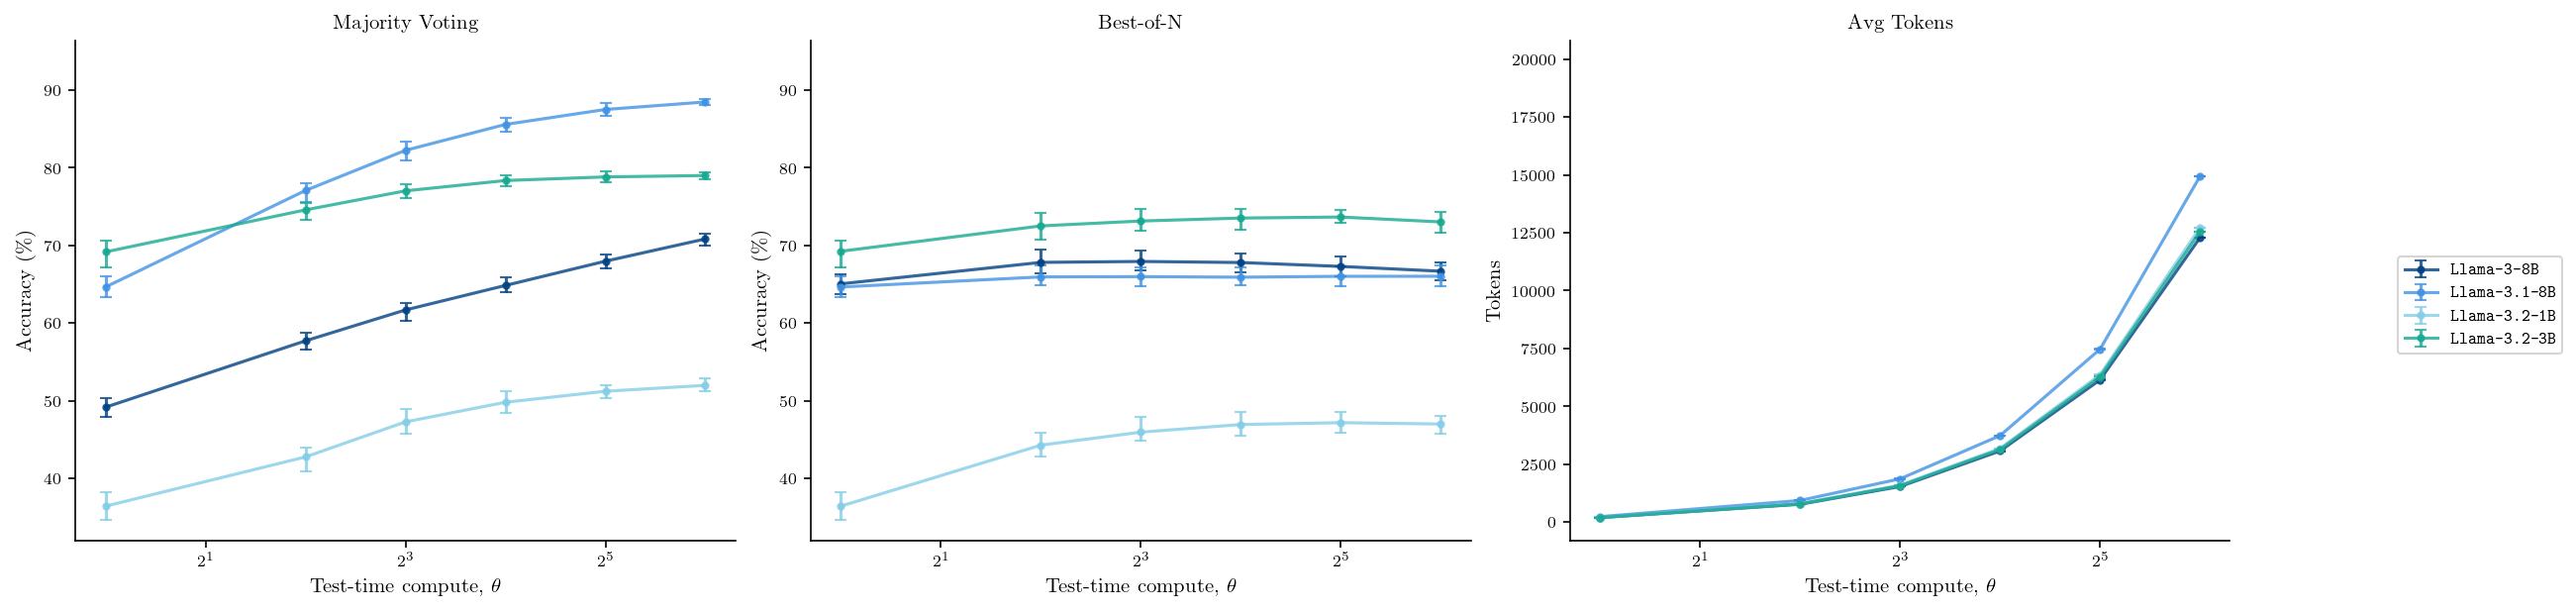

Saved 4 files to ../figures/GSM8K/accuracies/unreasoning/qwen/_*.pdf


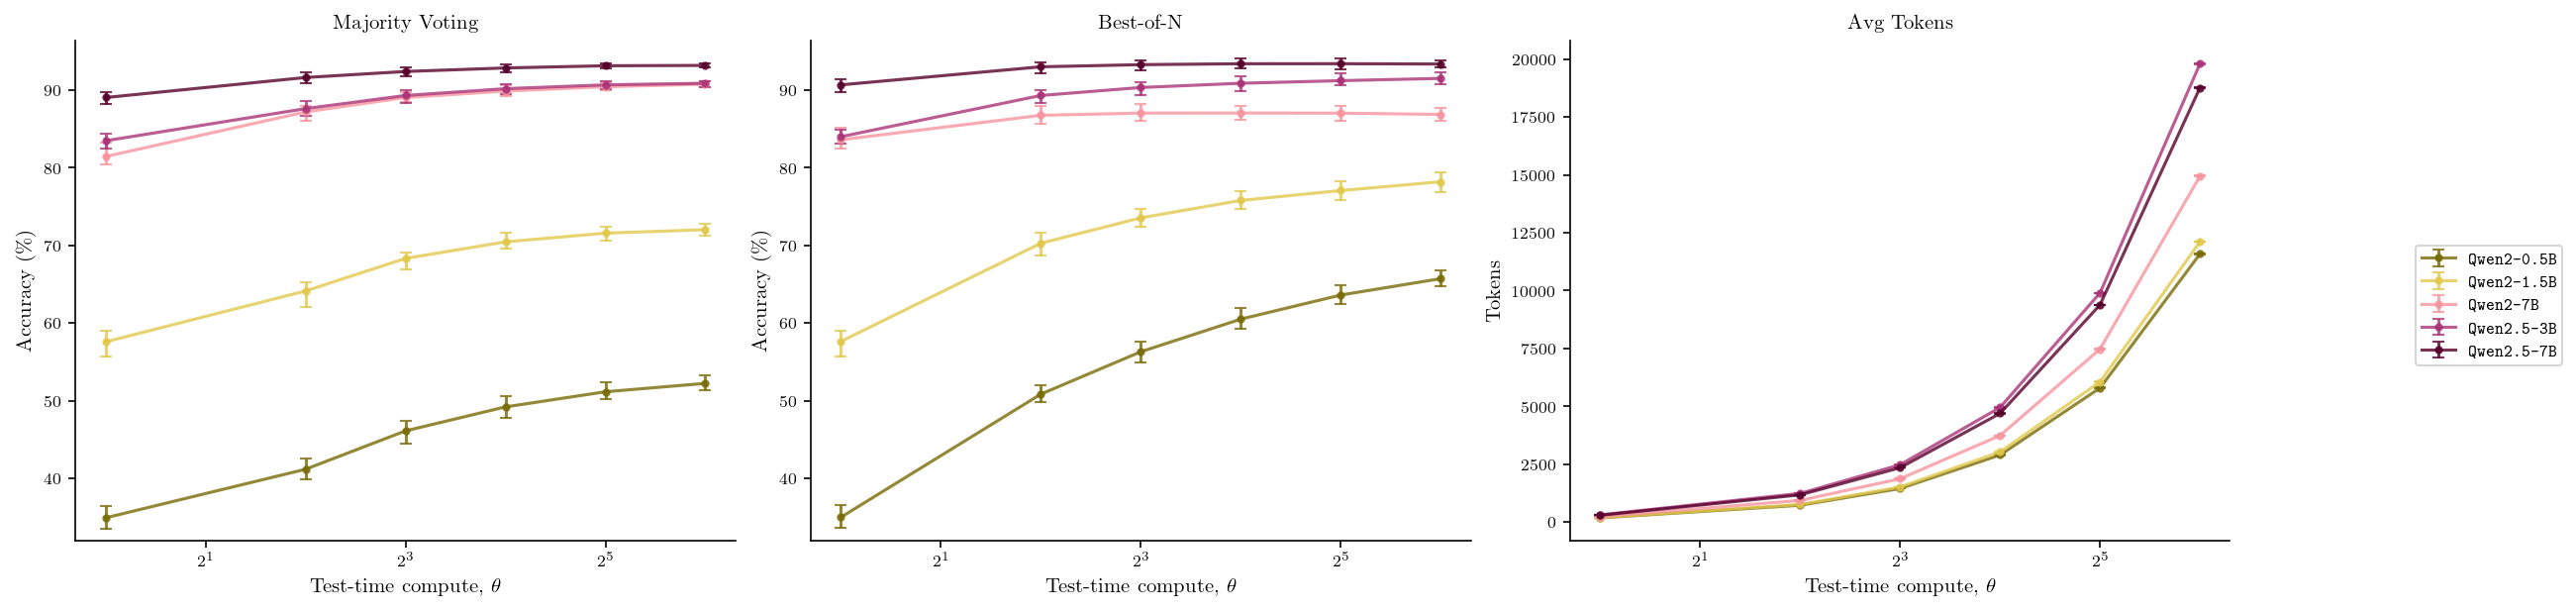

In [7]:
ut.save_separated_plots_overlaid(
    models_data_llama,
    f"../figures/{BENCHMARK}/accuracies/unreasoning/llama/",
    colors=model_color,
    ylim_accuracy=ylim_accuracy,
    ylim_tokens=ylim_tokens,
    samples_disp=False,
)

ut.save_separated_plots_overlaid(
    models_data_qwen,
    f"../figures/{BENCHMARK}/accuracies/unreasoning/qwen/",
    colors=model_color,
    ylim_accuracy=ylim_accuracy,
    ylim_tokens=ylim_tokens,
    samples_disp=True,
)

## Reasoning models

In [8]:
reasoning_plot_data = aa.reasoning_models_data(reasoning_models, results, B=2000)

Processing reason-R1-D-Llama-8B...
Processing reason-R1-D-Qwen-1.5B...
Processing reason-R1-D-Qwen-7B...


Saved separate files: ../figures/GSM8K/accuracies/reasoning/accuracy.pdf, ../figures/GSM8K/accuracies/reasoning/tokens.pdf, ../figures/GSM8K/accuracies/reasoning/legend.pdf


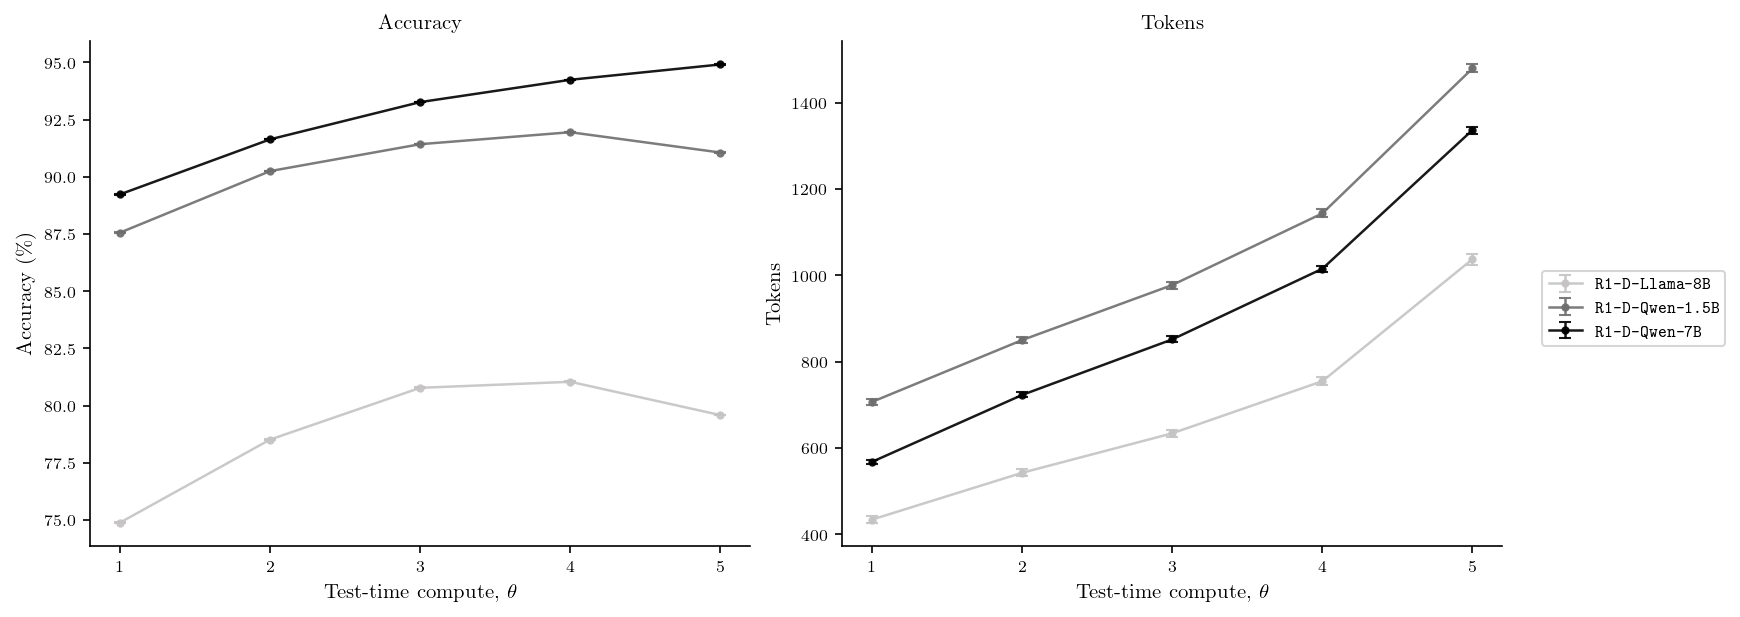

In [9]:
ut.save_reasoning_plots_separated(
    reasoning_plot_data,
    f"../figures/{BENCHMARK}/accuracies/reasoning/",
    colors=model_color,
)

# Dynamics analysis

In [10]:
config = gm.MarketConfig(
    alpha=0.008,
    default_margin=0.25,
    value_curve="linear",
)
thetas_unreasoning = np.array([1, 4, 8, 16, 32, 64])

## Non-reasoning models / Majority

In [11]:
ttc_type = "majority"
unreasoning_providers = gm.init_providers(unreasoning_models_data, ttc_type=ttc_type)

Initializing provider for Llama-3-8B...
Initializing provider for Llama-3.1-8B...
Initializing provider for Llama-3.2-1B...
Initializing provider for Llama-3.2-3B...
Initializing provider for Qwen2-0.5B...
Initializing provider for Qwen2-1.5B...
Initializing provider for Qwen2-7B...
Initializing provider for Qwen2.5-3B...
Initializing provider for Qwen2.5-7B...


### Value offered by providers vs compute level

Saved: ../figures/GSM8K/dynamics/unreasoning/majority/values/v_curves.pdf
Saved: ../figures/GSM8K/dynamics/unreasoning/majority/values/_legend.pdf


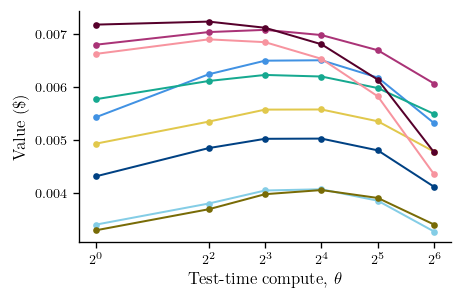

In [12]:
ut.plot_v_curves(
    gm.compute_V_curves(thetas_unreasoning, unreasoning_providers, config),
    thetas_unreasoning,
    config,
    f"../figures/{BENCHMARK}/dynamics/unreasoning/{ttc_type}/values/",
    colors=model_color,
)

### Analyze market dynamics

In [13]:
betas_to_test = [200, 1000, 100000]
profit_margin = 0.25

market_dynamics_unreasoning = gm.compute_market_dynamics(
    betas_to_test, profit_margin, unreasoning_providers, config
)

100%|██████████| 3/3 [00:15<00:00,  5.14s/it]


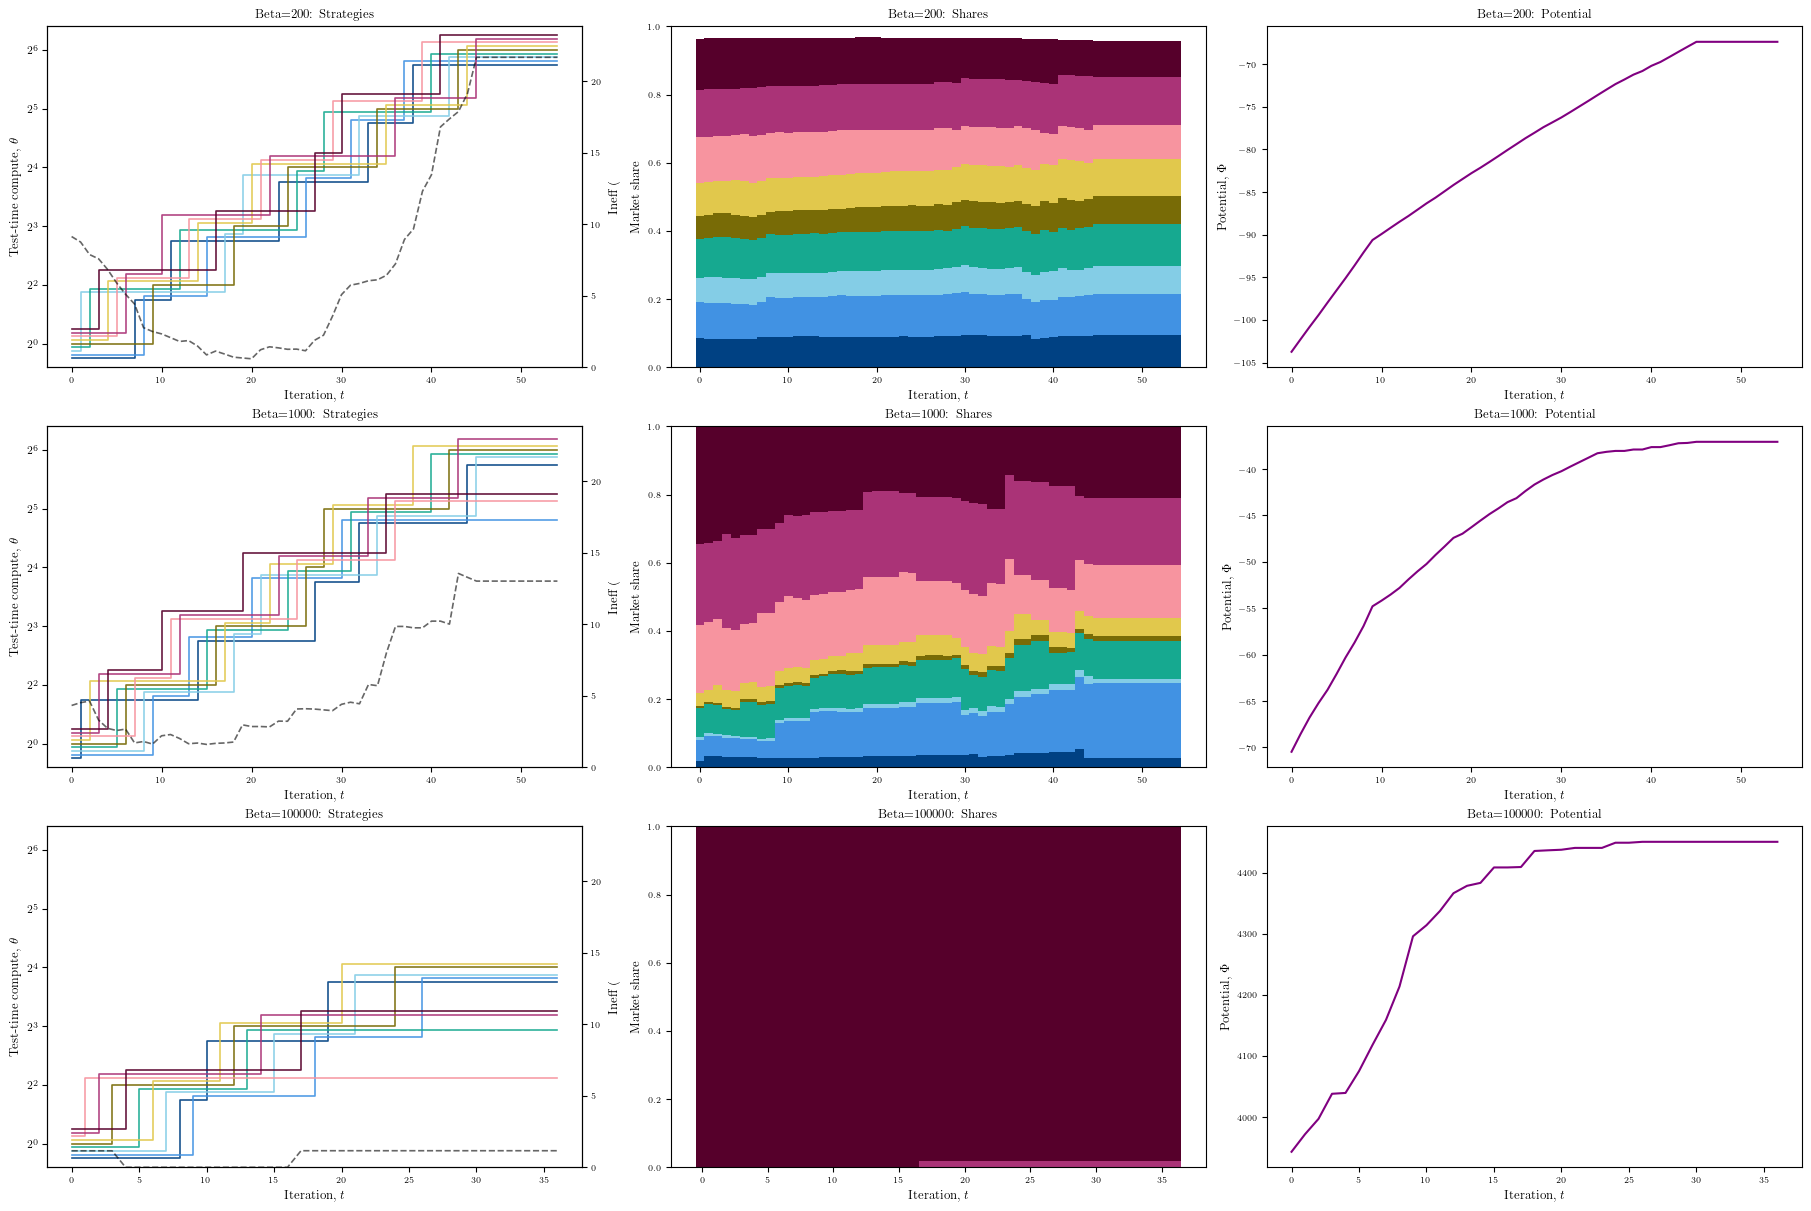

In [14]:
ut.bet_pot_analysis(
    unreasoning_providers,
    thetas_unreasoning,
    betas_to_test,
    market_dynamics_unreasoning,
    base_filename=f"../figures/{BENCHMARK}/dynamics/unreasoning/{ttc_type}/convergence/",
    colors=model_color,
    reasoning=False,
)

ut.plot_market_shares(
    unreasoning_providers,
    betas_to_test,
    market_dynamics_unreasoning,
    base_filename=f"../figures/{BENCHMARK}/dynamics/unreasoning/{ttc_type}/convergence/",
    colors=model_color,
)

ut.plot_combined_dynamics(
    unreasoning_providers,
    thetas_unreasoning,
    betas_to_test,
    market_dynamics_unreasoning,
    base_filename=f"../figures/{BENCHMARK}/dynamics/unreasoning/{ttc_type}/convergence/",
    colors=model_color,
    reasoning=False,
)

In [15]:
final_poas, final_potentials = gm.sweep_beta_vs_poa(unreasoning_providers, config, np.logspace(0, 6, num=100))

100%|██████████| 100/100 [09:40<00:00,  5.80s/it]


In [16]:
np.max(final_poas)

np.float64(1.2269566207491798)

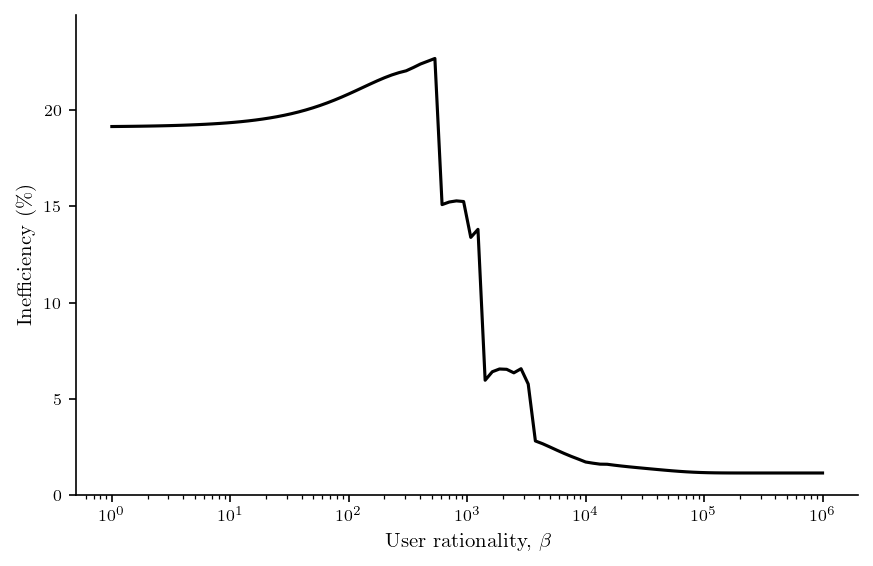

In [17]:
ut.plot_beta_sweep(
    np.logspace(0, 6, num=100),
    final_poas,
    f"../figures/{BENCHMARK}/dynamics/unreasoning/{ttc_type}/convergence/",
)

## Non-reasoning models / Best-of-N

In [18]:
ttc_type = "best-of-n"
unreasoning_providers = gm.init_providers(unreasoning_models_data, ttc_type=ttc_type)

Initializing provider for Llama-3-8B...
Initializing provider for Llama-3.1-8B...
Initializing provider for Llama-3.2-1B...
Initializing provider for Llama-3.2-3B...
Initializing provider for Qwen2-0.5B...
Initializing provider for Qwen2-1.5B...
Initializing provider for Qwen2-7B...
Initializing provider for Qwen2.5-3B...
Initializing provider for Qwen2.5-7B...


### Value offered by providers vs compute level

Saved: ../figures/GSM8K/dynamics/unreasoning/best-of-n/values/v_curves.pdf
Saved: ../figures/GSM8K/dynamics/unreasoning/best-of-n/values/_legend.pdf


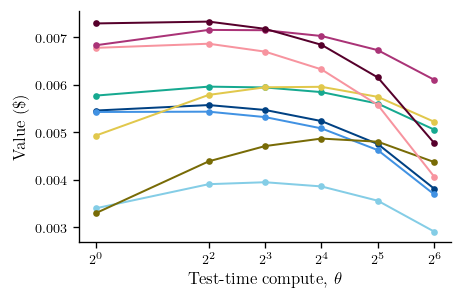

In [19]:
ut.plot_v_curves(
    gm.compute_V_curves(thetas_unreasoning, unreasoning_providers, config),
    thetas_unreasoning,
    config,
    f"../figures/{BENCHMARK}/dynamics/unreasoning/{ttc_type}/values/",
    colors=model_color,
)

### Analyze market dynamics

In [20]:
betas_to_test = [200, 1000, 100000]
profit_margin = 0.25

market_dynamics_unreasoning = gm.compute_market_dynamics(
    betas_to_test, profit_margin, unreasoning_providers, config
)

100%|██████████| 3/3 [00:15<00:00,  5.03s/it]


In [21]:
importlib.reload(ut)

<module 'scripts.utils' from '/NL/strategic-compute/work/strategic-ttc/notebooks/../scripts/utils.py'>

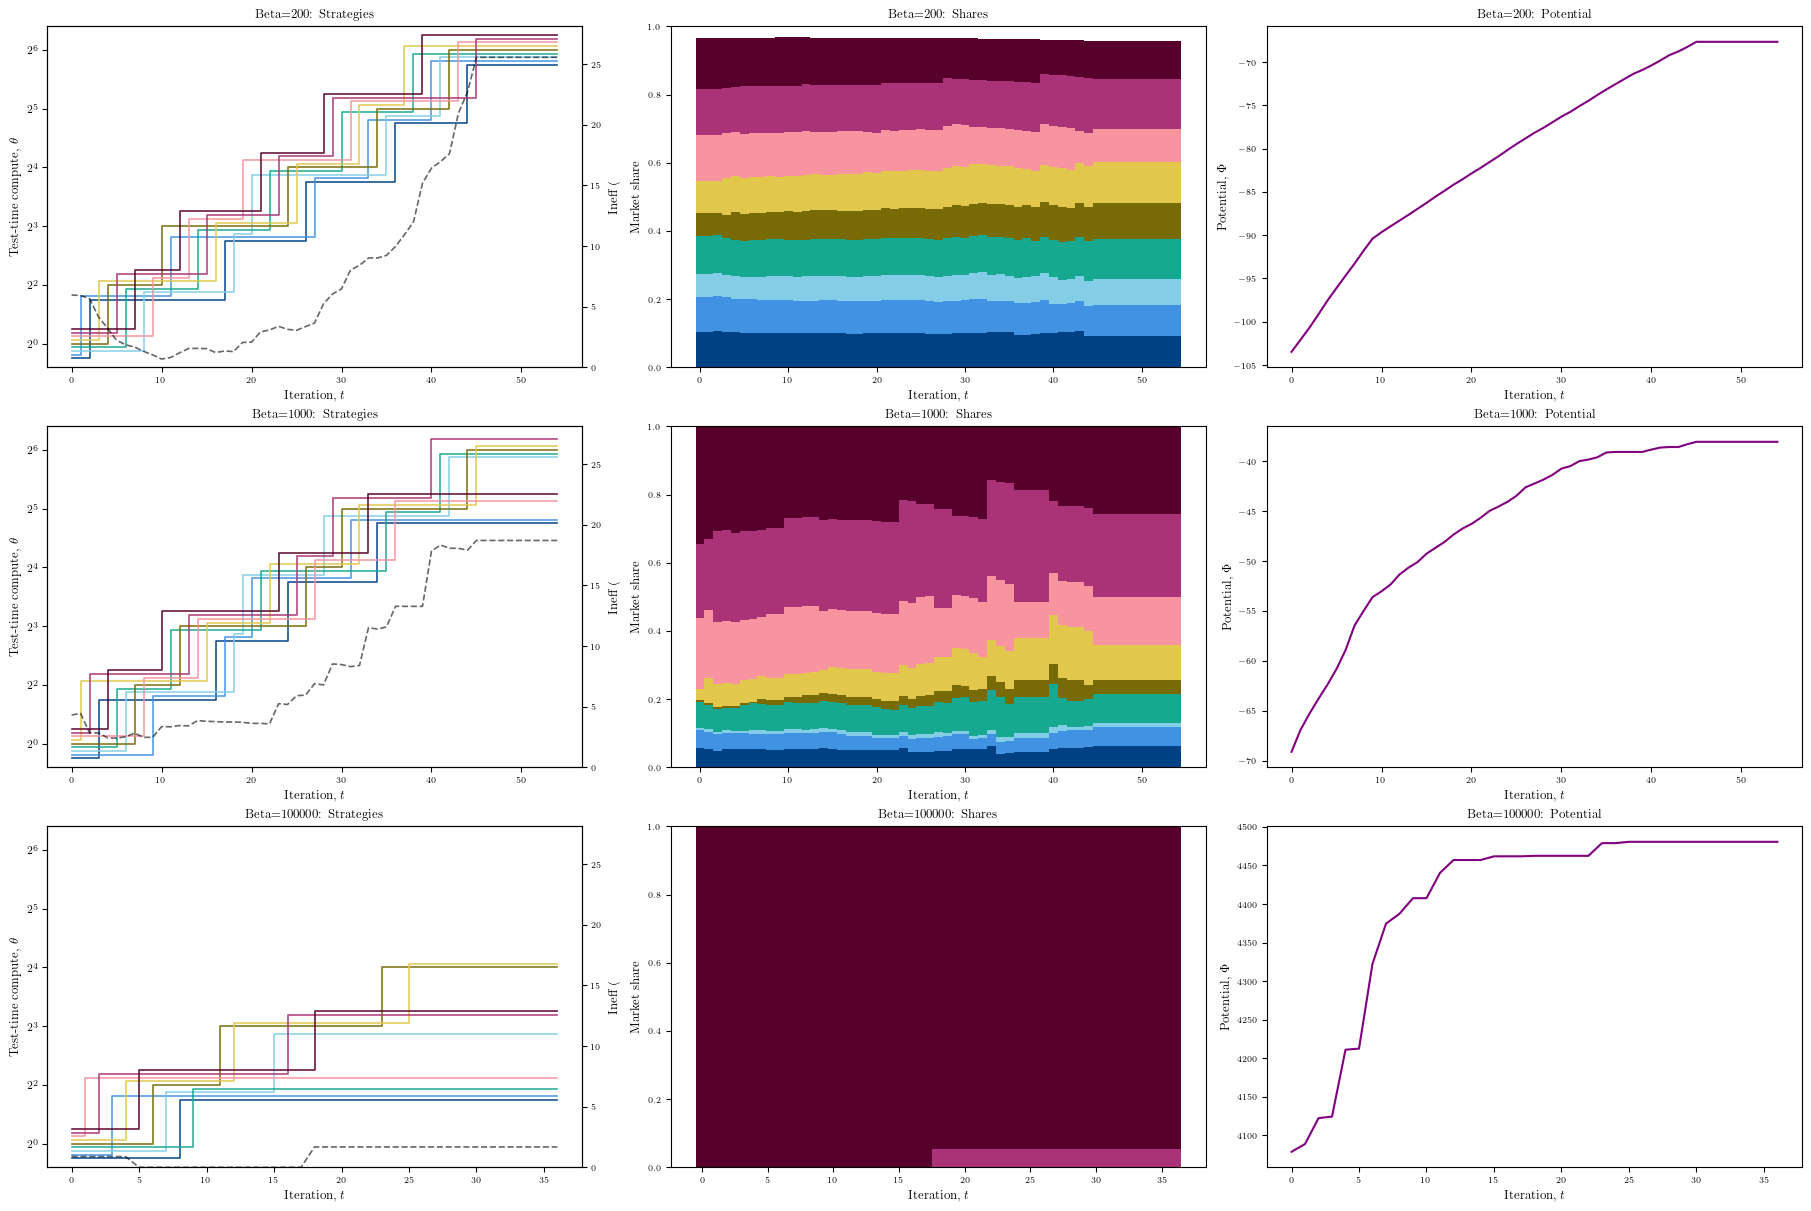

In [22]:
ut.bet_pot_analysis(
    unreasoning_providers,
    thetas_unreasoning,
    betas_to_test,
    market_dynamics_unreasoning,
    base_filename=f"../figures/{BENCHMARK}/dynamics/unreasoning/{ttc_type}/convergence/",
    colors=model_color,
    reasoning=False,
)

ut.plot_market_shares(
    unreasoning_providers,
    betas_to_test,
    market_dynamics_unreasoning,
    base_filename=f"../figures/{BENCHMARK}/dynamics/unreasoning/{ttc_type}/convergence/",
    colors=model_color,
)

ut.plot_combined_dynamics(
    unreasoning_providers,
    thetas_unreasoning,
    betas_to_test,
    market_dynamics_unreasoning,
    base_filename=f"../figures/{BENCHMARK}/dynamics/unreasoning/{ttc_type}/convergence/",
    colors=model_color,
    reasoning=False,
)

In [23]:
final_poas, final_potentials = gm.sweep_beta_vs_poa(unreasoning_providers, config, np.logspace(0, 6, num=100))

100%|██████████| 100/100 [09:40<00:00,  5.81s/it]


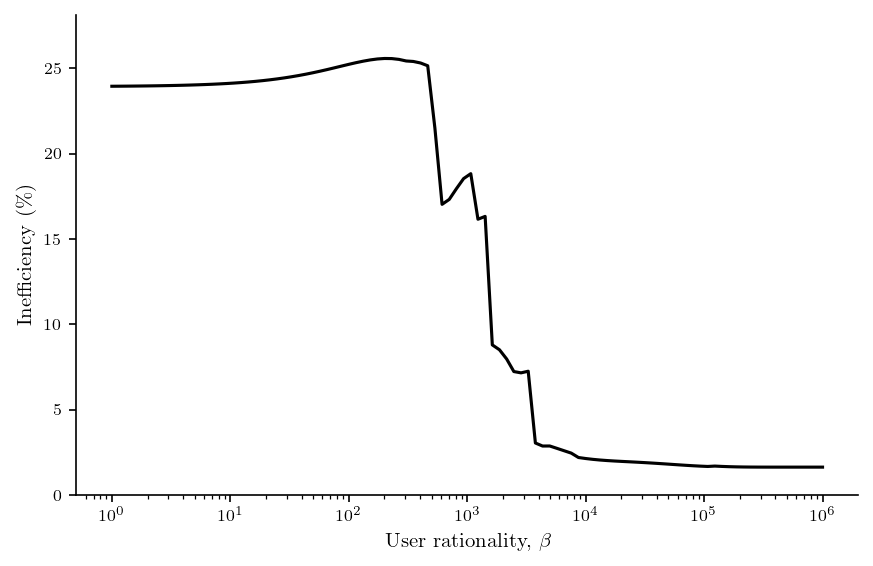

In [24]:
ut.plot_beta_sweep(
    np.logspace(0, 6, num=100),
    final_poas,
    f"../figures/{BENCHMARK}/dynamics/unreasoning/{ttc_type}/convergence/",
)

## Reasoning models

In [25]:
ttc_type = "relative_efforts"
reasoning_providers = gm.init_providers(reasoning_plot_data, ttc_type=ttc_type)
thetas_reasoning = np.array([1, 2, 3, 4, 5])

Initializing provider for reason-R1-D-Llama-8B...
Initializing provider for reason-R1-D-Qwen-1.5B...
Initializing provider for reason-R1-D-Qwen-7B...


### Value offered by providers vs compute level

In [26]:
importlib.reload(ut)

<module 'scripts.utils' from '/NL/strategic-compute/work/strategic-ttc/notebooks/../scripts/utils.py'>

Saved: ../figures/GSM8K/dynamics/reasoning/relative_efforts/values/v_curves.pdf
Saved: ../figures/GSM8K/dynamics/reasoning/relative_efforts/values/_legend.pdf


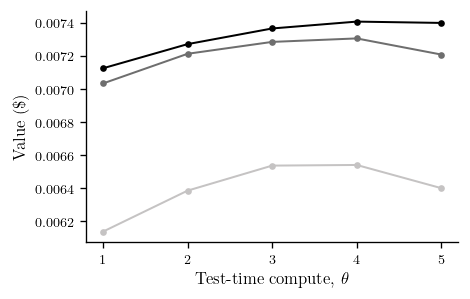

In [27]:
ut.plot_v_curves(
    gm.compute_V_curves(thetas_reasoning, reasoning_providers, config),
    thetas_reasoning,
    config,
    f"../figures/{BENCHMARK}/dynamics/reasoning/{ttc_type}/values/",
    colors=model_color,
    reasoning=True
)

### Analyze market dynamics

In [28]:
betas_to_test = [200, 1000, 100000]
profit_margin = 0.25

market_dynamics_reasoning = gm.compute_market_dynamics(
    betas_to_test, profit_margin, reasoning_providers, config
)

100%|██████████| 3/3 [00:00<00:00, 465.43it/s]


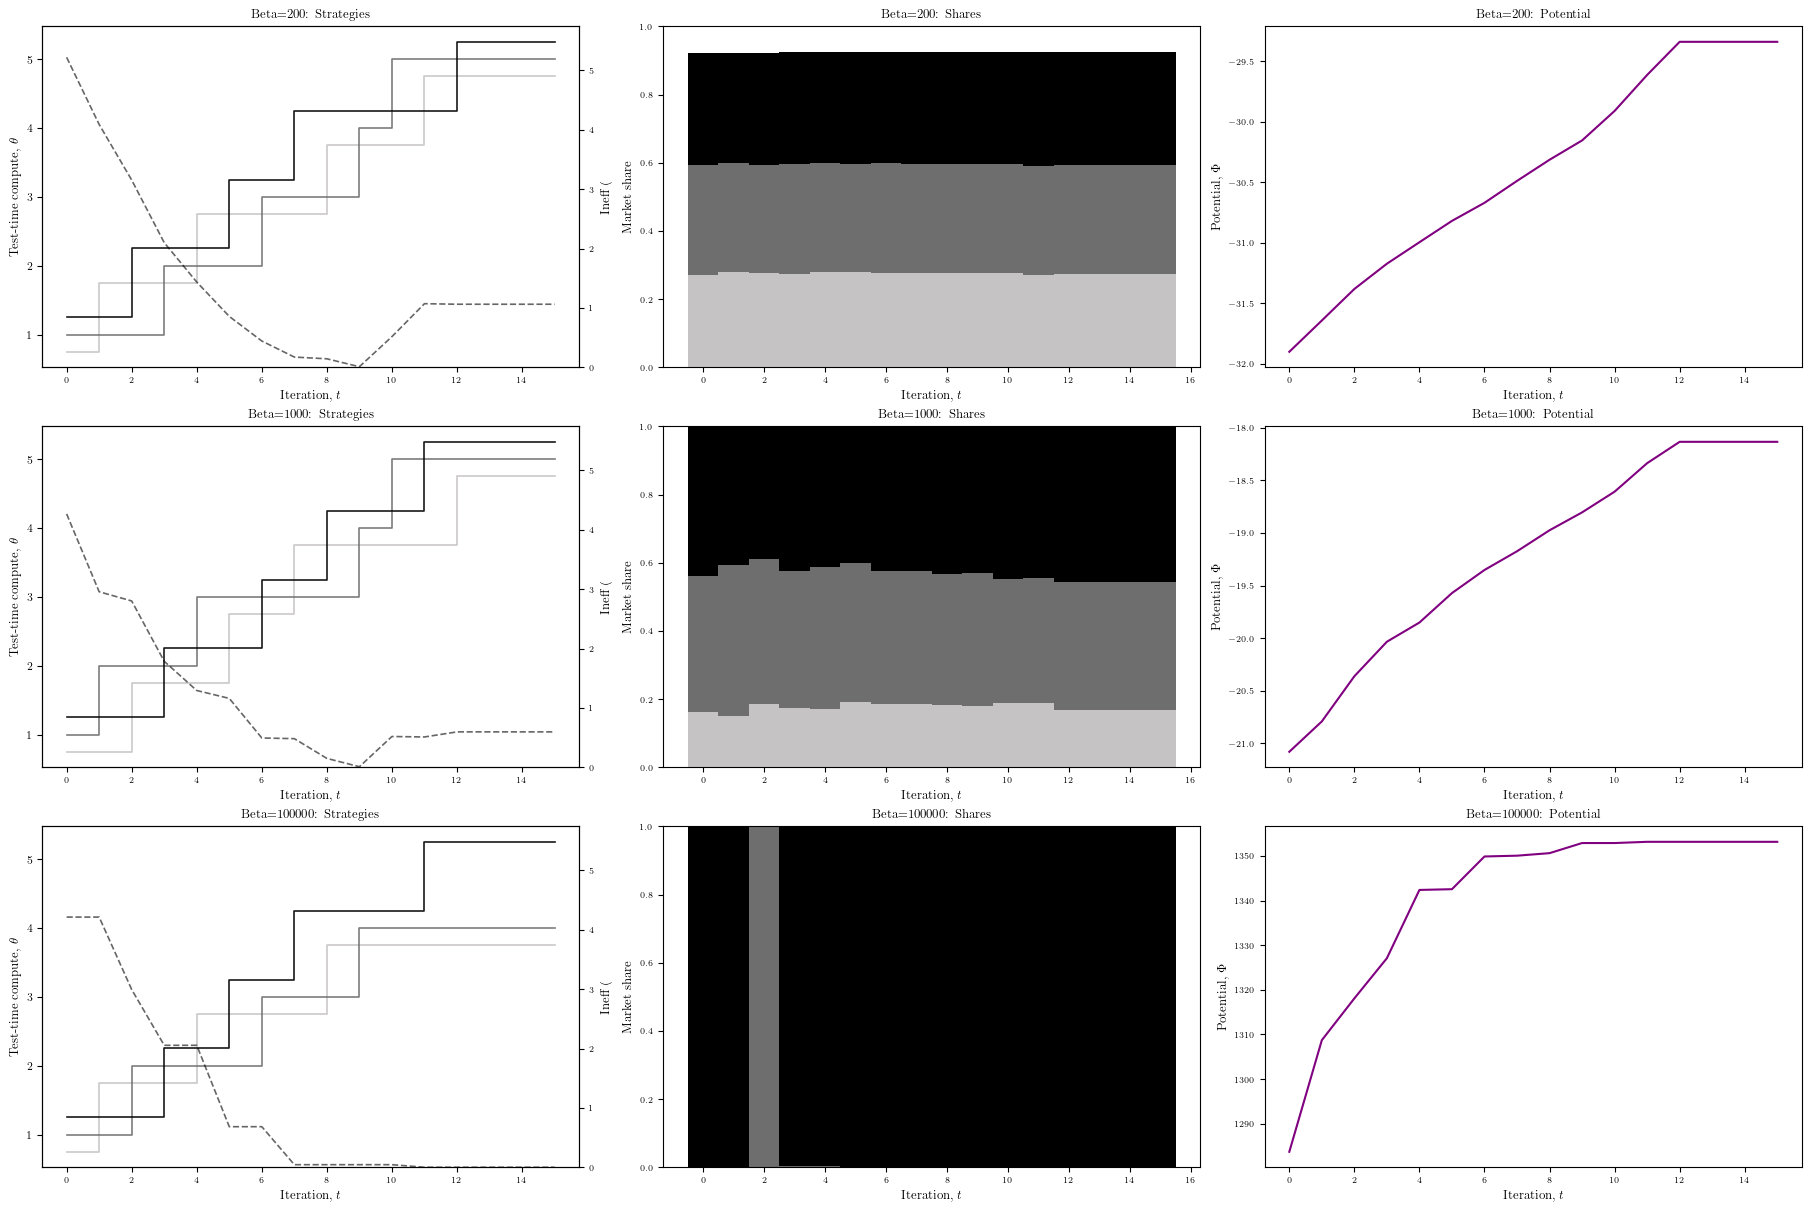

In [29]:
ut.bet_pot_analysis(
    reasoning_providers,
    thetas_reasoning,
    betas_to_test,
    market_dynamics_reasoning,
    base_filename=f"../figures/{BENCHMARK}/dynamics/reasoning/{ttc_type}/convergence/",
    colors=model_color,
    reasoning=True,
)

ut.plot_market_shares(
    reasoning_providers,
    betas_to_test,
    market_dynamics_reasoning,
    base_filename=f"../figures/{BENCHMARK}/dynamics/reasoning/{ttc_type}/convergence/",
    colors=model_color,
)

ut.plot_combined_dynamics(
    reasoning_providers,
    thetas_reasoning,
    betas_to_test,
    market_dynamics_reasoning,
    base_filename=f"../figures/{BENCHMARK}/dynamics/reasoning/{ttc_type}/convergence/",
    colors=model_color,
    reasoning=True,
)

In [30]:
final_poas, final_potentials = gm.sweep_beta_vs_poa(reasoning_providers, config, np.logspace(0, 6, num=100))

100%|██████████| 100/100 [00:00<00:00, 416.23it/s]


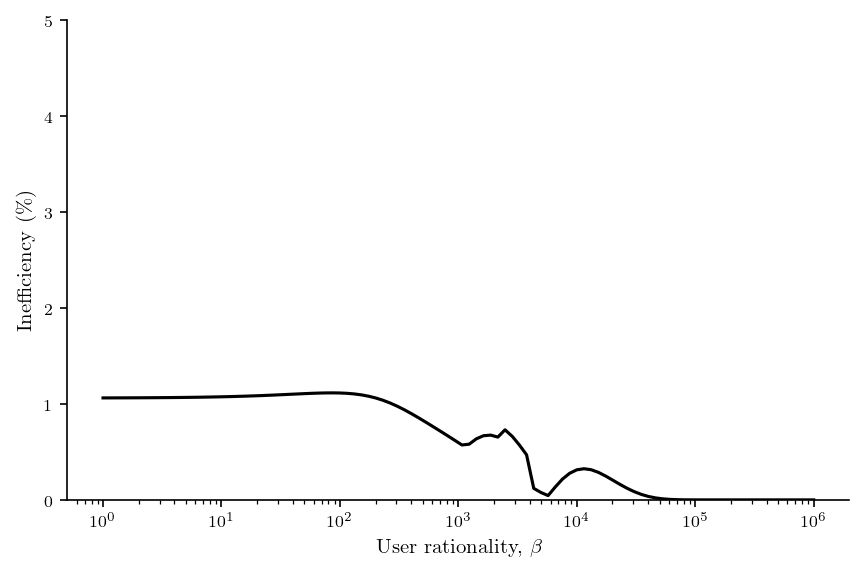

In [31]:
ut.plot_beta_sweep(
    np.logspace(0, 6, num=100),
    final_poas,
    f"../figures/{BENCHMARK}/dynamics/reasoning/{ttc_type}/convergence/",
)